# Brain Tumor Classification

In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Data Preparation

In [ ]:
tumor_dir_path='../input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
non_tumor_path='../input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
filepaths = []
labels= []
dict_list = [tumor_dir_path, non_tumor_path]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('brain_tumor')
        else:
          labels.append('good_health') 
    
fpath_s = pd.Series(filepaths, name="filepaths")
lbl_s = pd.Series(labels, name="lbl")
tumor_data = pd.concat([fpath_s,lbl_s], axis=1)
df = pd.DataFrame(tumor_data)
print(df["lbl"].value_counts())


brain_tumor    2513
good_health    2087
Name: lbl, dtype: int64


# Data Distribution

<AxesSubplot:>

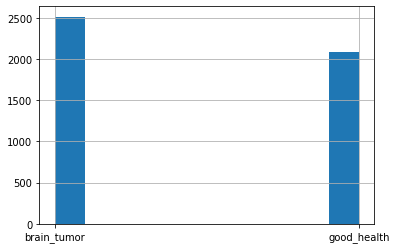

In [ ]:
df.lbl.hist()

# Data Augmentation

In [ ]:
# Augment data
batch_size = 64
train_input_shape = (224, 224, 3)
n_classes = 2
classes = ['brain_tumor', 'good_health']
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=15,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=0.1,
                                   zoom_range=0.5,
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_dataframe(dataframe= df,x_col="filepaths",y_col="lbl",
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=classes
                                                   )

valid_generator = train_datagen.flow_from_dataframe(dataframe= df,x_col="filepaths",y_col="lbl",
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=classes
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3680 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.
Total number of batches = 57 and 14


# Visualization

In [ ]:
def brain_images(image_gen):
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

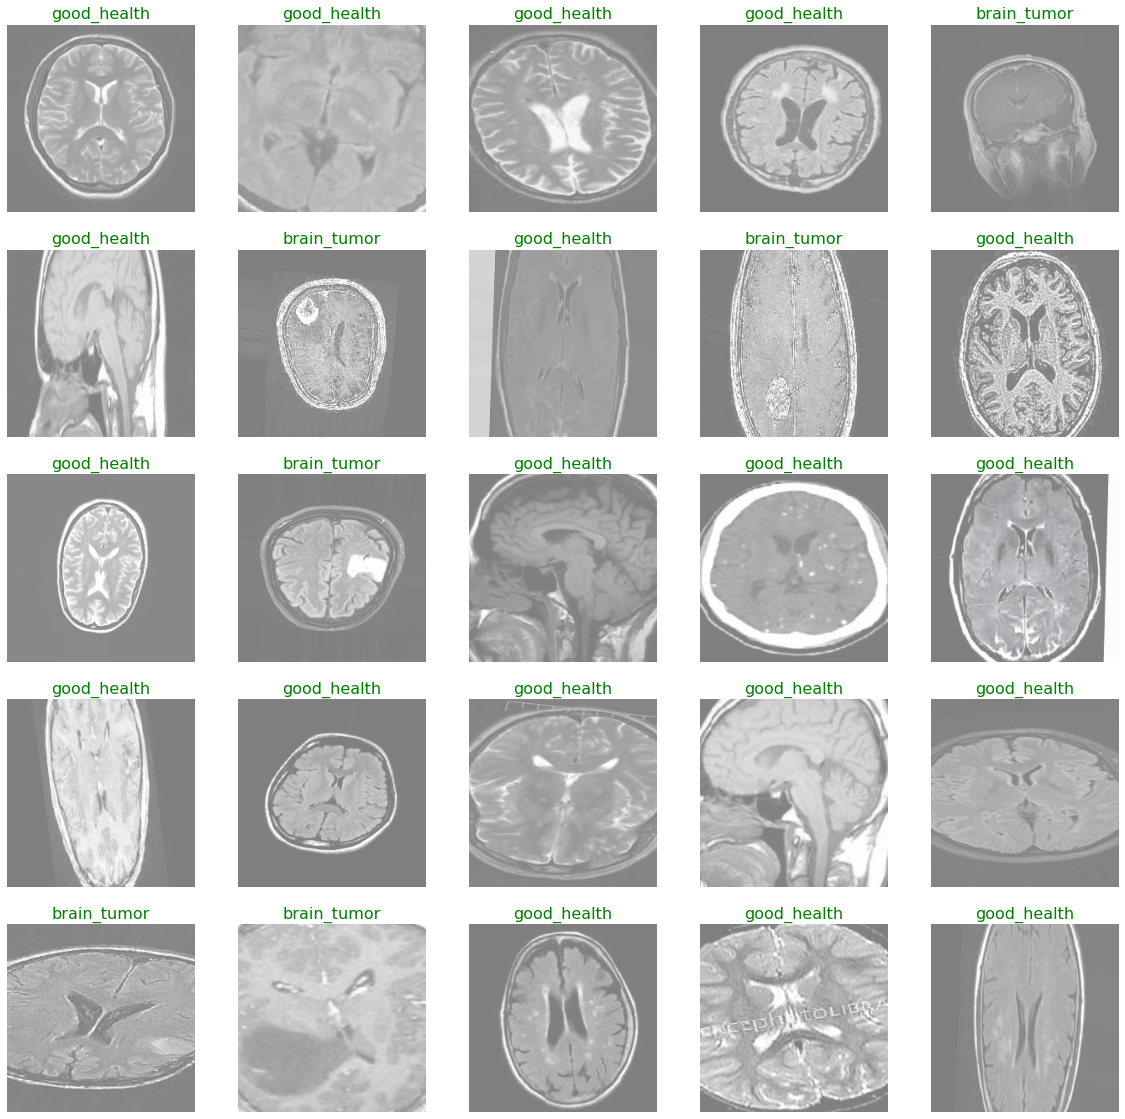

In [ ]:
brain_images(train_generator)

# Transfer Learning using Resnet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True
    
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = Dropout(0.4)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(128, kernel_initializer='he_uniform')(X)
X = Dropout(0.4)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = Dropout(0.4)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)


94773248/94765736 [==============================] - 0s 0us/step


# Training

In [ ]:
optimizer = Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [ ]:
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [ ]:
##### Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=4
                             )

Epoch 1/30
57/57 [==============================] - 71s 1s/step - loss: 0.7343 - accuracy: 0.5862 - val_loss: 0.9903 - val_accuracy: 0.0112
Epoch 2/30
57/57 [==============================] - 60s 1s/step - loss: 0.5395 - accuracy: 0.7260 - val_loss: 0.7920 - val_accuracy: 0.1027
Epoch 3/30
57/57 [==============================] - 61s 1s/step - loss: 0.4851 - accuracy: 0.7518 - val_loss: 0.7143 - val_accuracy: 0.4163
Epoch 4/30
57/57 [==============================] - 60s 992ms/step - loss: 0.4294 - accuracy: 0.8053 - val_loss: 0.7274 - val_accuracy: 0.3783
Epoch 5/30
57/57 [==============================] - 60s 1s/step - loss: 0.3974 - accuracy: 0.8317 - val_loss: 0.7330 - val_accuracy: 0.3304
Epoch 6/30
57/57 [==============================] - 60s 1s/step - loss: 0.3608 - accuracy: 0.8593 - val_loss: 0.7479 - val_accuracy: 0.2600
Epoch 7/30
57/57 [==============================] - 62s 1s/step - loss: 0.3355 - accuracy: 0.8804 - val_loss: 0.6942 - val_accuracy: 0.4810
Epoch 8/30
57/57 

In [ ]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator)
print("Prediction accuracy on train data =", score[1])

Prediction accuracy on train data = 0.9817934632301331


In [ ]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator)
print("Prediction accuracy on CV data =", score[1])

Prediction accuracy on CV data = 0.949999988079071


# Report

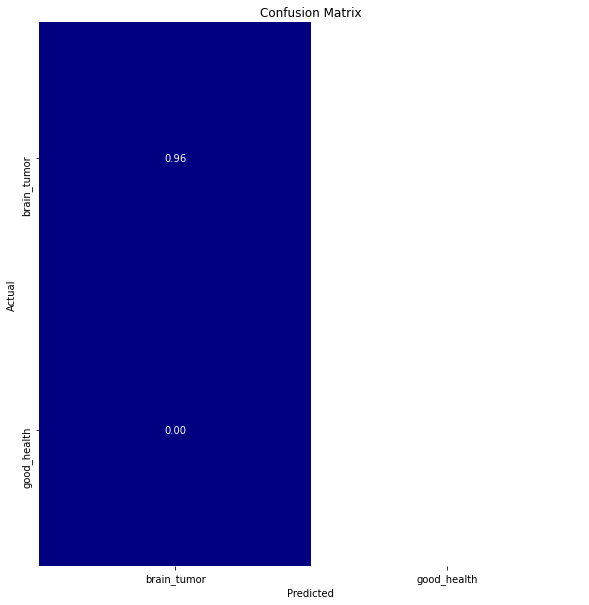

Classification Report:
              precision    recall  f1-score   support

 brain_tumor       1.00      0.96      0.98       896
 good_health       0.00      0.00      0.00         0

    accuracy                           0.96       896
   macro avg       0.50      0.48      0.49       896
weighted avg       1.00      0.96      0.98       896



In [ ]:
from sklearn.metrics import *
import seaborn as sns

tick_labels = classes

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=classes))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)


In [ ]:
model.save('./model.h5')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/model.h5')

In [ ]:
model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
model.evaluate_generator(train_generator)

[0.20469489693641663, 0.9842391014099121]